In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import warnings
from nltk import word_tokenize, pos_tag, FreqDist, SnowballStemmer
from nltk.corpus import wordnet as wn, stopwords
from gensim import corpora, models
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from wordcloud import WordCloud
from nltk.util import ngrams

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

C:\Users\Michael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')
userComments3 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (200-300k).csv')

userComments3['Unnamed: 0'] = userComments3['Unnamed: 0'].astype('float64')
userComments3['Userscore'] = userComments3['Userscore'].astype('float64')

userComments = pd.concat([userComments1, userComments2, userComments3], axis = 0)
userComments.drop(columns = 'Unnamed: 0', inplace = True)
userComments.dropna(how = 'all', inplace = True)

userComments.Platform.unique()

platformMap = {
'Nintendo64': 'Nintendo',
'GameBoyAdvance': 'Nintendo',
'3DS': 'Nintendo',
'DS': 'Nintendo',
'Wii': 'Nintendo',
'Switch': 'Nintendo',
'WiiU': 'Nintendo',
'GameCube': 'Nintendo',
'PlayStation': 'PlayStation',
'PlayStation3': 'PlayStation',
'PlayStation2': 'PlayStation',
'PlayStation4': 'PlayStation',
'PlayStationVita': 'PlayStation',
'PSP': 'PlayStation',
'Xbox360': 'Xbox',
'Xbox': 'Xbox',
'XboxOne': 'Xbox',
'PC': 'PC',
'Dreamcast': 'Others',
'not specified': 'Others'
}

userComments['platformCondensed'] = userComments.Platform.map(platformMap)

In [31]:
filter_list = ["would", "could", "left", "right", "a.m.", "p.m.", "'s", "! ! !", "...", ":", ";", "n't",
              "game", "games", "play", "fun", "much", "one", "great", "time", "year", "lot", "thing", "etc"]

def preprocess_text(tokens, needtokenizeBoolean = True, grams = False,  ngramsNumber = 2, furtherPreProcessNgrams = False):
    
    if needtokenizeBoolean:
        tokens = nltk.word_tokenize(tokens)
        if grams:
            tokens = list(ngrams(tokens, ngramsNumber))
    if grams:
        tokens = [' '.join(gram) for gram in tokens]
        if furtherPreProcessNgrams == False:
            return tokens
            
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords.words('english') + filter_list]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if not t.isnumeric()]
    snowball = SnowballStemmer('english')
    tokens = [snowball.stem(t) for t in tokens]
    
    return tokens

def wc(df, columnName, preProcessingFunctionBoolean = True, tfidfVectorizerBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7, countVectorizerBinary = True,
       nounTaggingBoolean = False, universalNounTagsetBoolean = False, ngrams = False, ngramsNumber = 2, furtherPreProcessNgrams = False,
       top = 10, features_improvements = 'Word Cloud', platform = 'All'):

    if preProcessingFunctionBoolean == True & ngrams == True:
        if tfidfVectorizerBoolean == True:
            if furtherPreProcessNgrams == True:
                tdm = TfidfVectorizer(tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber, furtherPreProcessNgrams = True), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if furtherPreProcessNgrams == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber, furtherPreProcessNgrams = True), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber), min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])
    
    if nounTaggingBoolean == True and ngrams == False:
        noun_list = []
        for value in df[columnName]:
            if universalNounTagsetBoolean == True:
                tagged_value = pos_tag(word_tokenize(value), tagset='universal')
                noun = [word for word, tag in tagged_value if tag == 'NOUN']
            else:
                tagged_value = pos_tag(word_tokenize(value))
                noun = [word for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']
            noun_list.append(noun)
        df['Text_NounOnly'] = noun_list
        if preProcessingFunctionBoolean == True:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: preprocess_text(tokens = x, needtokenizeBoolean = False))
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        else:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        if tfidfVectorizerBoolean == True:
            tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df['Text_NounOnly'])
        
    if nounTaggingBoolean != True and ngrams == False:
        if tfidfVectorizerBoolean == True:
            if preProcessingFunctionBoolean == True:
                tdm = TfidfVectorizer(tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if preProcessingFunctionBoolean == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])

    array = tdmMatrix.toarray()
    feature_names = tdm.get_feature_names_out()
    word_tfidf = dict(zip(feature_names, array.sum(axis=0)))
    fd_tfidf= FreqDist(word_tfidf)
    wc = WordCloud(background_color="white").generate_from_frequencies(fd_tfidf)
    plt.figure()
    plt.suptitle(f"{features_improvements} ({platform})", fontsize = 20, x = 0.5, y = 0.85, fontweight = 'bold', fontname = 'Calibri') 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    displayList = []
    for x,y in fd_tfidf.most_common(top):
        displayList.append((x, round(y, 2)))

    plt.show()
    print(displayList)

In [10]:
userComments.shape

(283983, 6)

In [11]:
# TO REMOVE THIS CELL AND RENAME BELOW CELLS EVENTUALLY!!
userCommentsTEST = userComments.sample(10000).copy()

In [27]:
userCommentsTEST.Userscore.value_counts().sort_index(ascending = False)

Userscore
10.0    3984
9.0     1877
8.0     1067
7.0      625
6.0      404
5.0      342
4.0      298
3.0      224
2.0      214
1.0      255
0.0      710
Name: count, dtype: int64

In [28]:
# Assumption: Game creators will want to focus on problems where they can fix and do better than improving what's already good (more weights on low userscores?)

userCommentsTESTNotNull = userCommentsTEST[userCommentsTEST.Comment.notnull()]

userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore > 9, 'scoreBin'] = 'High'
userCommentsTESTNotNull.loc[(userCommentsTESTNotNull.Userscore >= 3) & (userCommentsTESTNotNull.Userscore <= 9), 'scoreBin'] = 'Medium'
userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore < 3, 'scoreBin'] = 'Low'

userCommentsTESTHigh = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'High']
userCommentsTESTLow = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'Low']

In [29]:
platformCondensed_list = list(userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin != 'Medium'].platformCondensed.unique())
userCommentsTESTExtreme_list = [userCommentsTESTHigh, userCommentsTESTLow]

for platform in platformCondensed_list:
    for df in userCommentsTESTExtreme_list:
        print(f"{platform}, {df.reset_index().scoreBin[0]} Userscore; No. of comments: {df[df.platformCondensed == platform].shape[0]}")

PlayStation, High Userscore; No. of comments: 1243
PlayStation, Low Userscore; No. of comments: 293
Nintendo, High Userscore; No. of comments: 578
Nintendo, Low Userscore; No. of comments: 46
PC, High Userscore; No. of comments: 1516
PC, Low Userscore; No. of comments: 634
Xbox, High Userscore; No. of comments: 631
Xbox, Low Userscore; No. of comments: 206
Others, High Userscore; No. of comments: 15
Others, Low Userscore; No. of comments: 0


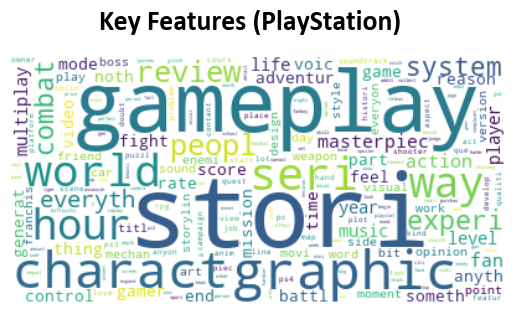

[('stori', 63.76), ('gameplay', 43.94), ('graphic', 41.78), ('charact', 38.13), ('seri', 30.82), ('world', 28.79), ('way', 25.96), ('hour', 25.92), ('peopl', 25.51), ('review', 24.63)]


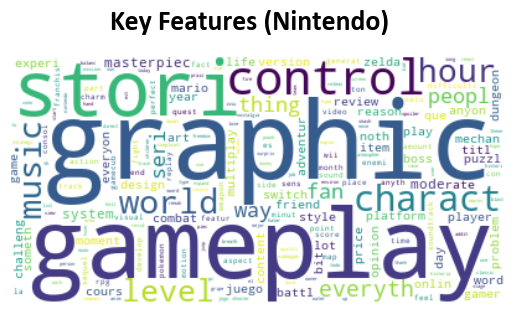

[('graphic', 19.51), ('gameplay', 18.9), ('stori', 18.15), ('control', 17.21), ('charact', 16.75), ('world', 14.88), ('music', 14.43), ('hour', 13.3), ('level', 12.87), ('everyth', 11.91)]


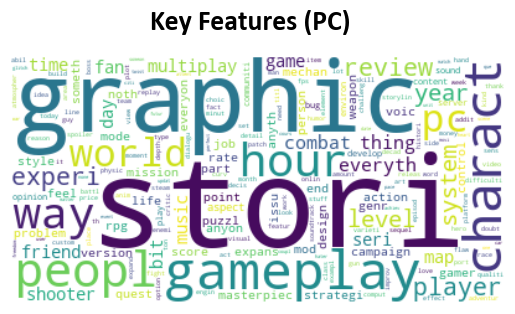

[('stori', 58.21), ('graphic', 51.07), ('gameplay', 40.98), ('charact', 39.87), ('peopl', 35.04), ('hour', 32.26), ('way', 30.81), ('world', 28.72), ('pc', 28.32), ('player', 27.58)]


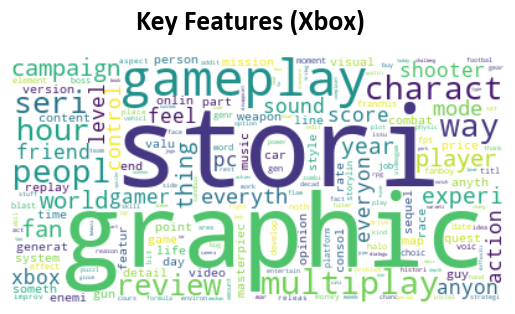

[('stori', 27.26), ('graphic', 23.05), ('gameplay', 17.94), ('multiplay', 17.74), ('charact', 15.81), ('way', 15.22), ('peopl', 15.05), ('hour', 14.44), ('seri', 13.93), ('review', 12.84)]


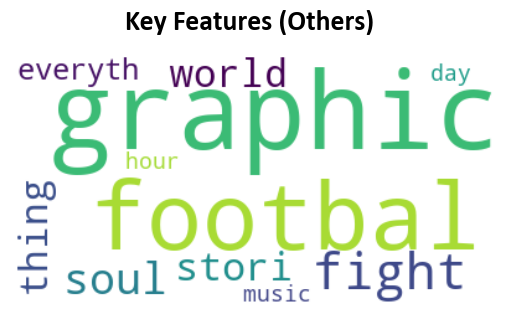

[('graphic', 2.52), ('footbal', 1.8), ('fight', 1.77), ('soul', 1.26), ('stori', 1.07), ('thing', 1.0), ('world', 0.97), ('everyth', 0.91), ('day', 0.46), ('hour', 0.46)]


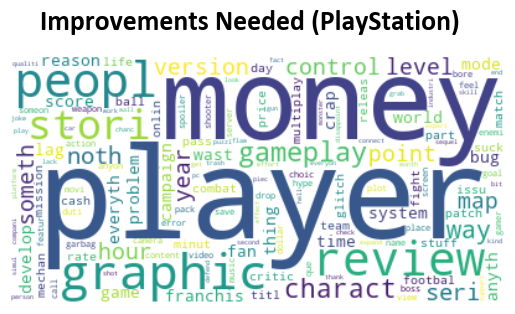

[('player', 9.65), ('money', 9.25), ('graphic', 9.14), ('peopl', 8.73), ('review', 8.5), ('stori', 8.17), ('gameplay', 8.1), ('charact', 7.59), ('way', 6.83), ('noth', 6.3)]


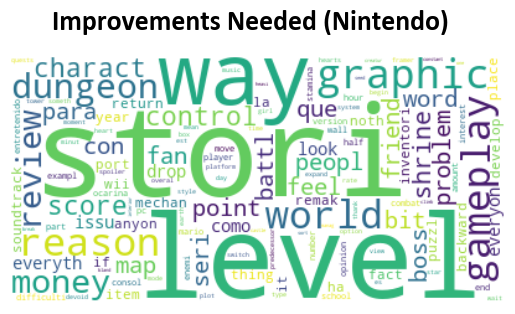

[('stori', 3.18), ('level', 2.65), ('way', 2.41), ('graphic', 2.23), ('reason', 2.11), ('gameplay', 2.04), ('world', 1.98), ('dungeon', 1.97), ('money', 1.85), ('review', 1.84)]


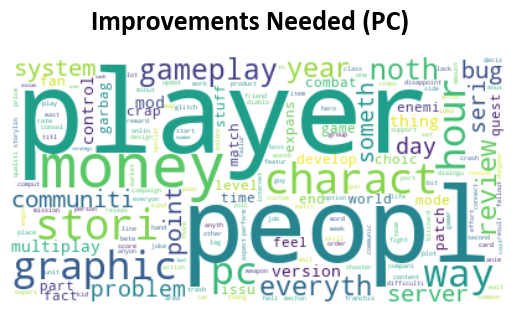

[('player', 20.81), ('peopl', 16.81), ('money', 16.08), ('charact', 14.96), ('stori', 14.64), ('graphic', 13.43), ('hour', 13.01), ('pc', 12.89), ('way', 12.34), ('gameplay', 12.28)]


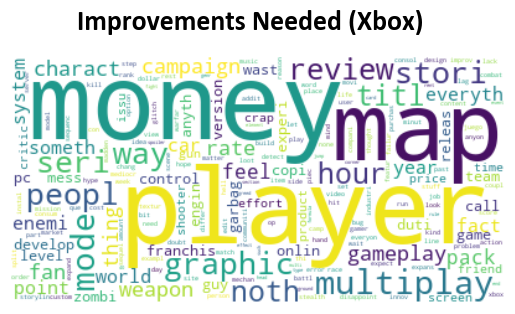

[('money', 7.96), ('player', 7.86), ('map', 7.13), ('multiplay', 7.1), ('mode', 6.43), ('graphic', 6.18), ('seri', 6.15), ('stori', 5.93), ('peopl', 5.81), ('way', 5.61)]


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [32]:
%%time

# Can adjust the parameters in this function to fine tune and iterate testings. Can adjust score bins, sample size and filter list above too!
# If ngrams = True, preProcessingFunctionBoolean needs to be True
# ValueError: max_df corresponds to < documents than min_df; ValueError: empty vocabulary - perhaps the documents only contain stop words .. If get these errors, it may simply be because of small sample size (less than min or 0)

for df in userCommentsTESTExtreme_list:
    for platform in platformCondensed_list:
            if df.scoreBin.max() == 'High':
                features_improvements = 'Key Features'
            elif df.scoreBin.max() == 'Low':
                features_improvements = 'Improvements Needed'
            wc(df = df[df.platformCondensed == platform], columnName = 'Comment',
               preProcessingFunctionBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7,
               countVectorizerBinary = True, tfidfVectorizerBoolean = True,
               ngrams = False, ngramsNumber = 3, furtherPreProcessNgrams = False,
               nounTaggingBoolean = True, universalNounTagsetBoolean = False,
               top = 10, features_improvements = features_improvements, platform = platform)